# DPC TODO

- Confirm conversion to potential is correct
- Check about diffraction space pixel calibrations
- Include probe deconvolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import h5py
from scipy.ndimage.filters import gaussian_filter

import py4DSTEM
from py4DSTEM.process.calibration import get_probe_size
from py4DSTEM.process.dpc import get_CoM_images, get_rotation_and_flip, get_phase_from_CoM
from py4DSTEM.process.dpc import get_wavenumber, get_interaction_constant

In [2]:
# Load data

fp = "/home/ben/Data/20190509_DPC_MoS2_binned_HamishBrown/MoS2_binned.h5"
f = h5py.File(fp,'r')
data = np.array(f['4D-STEM_data/datacube/datacube'])
f.close()

dc = py4DSTEM.file.datastructure.DataCube(data[:,:255,:,:])

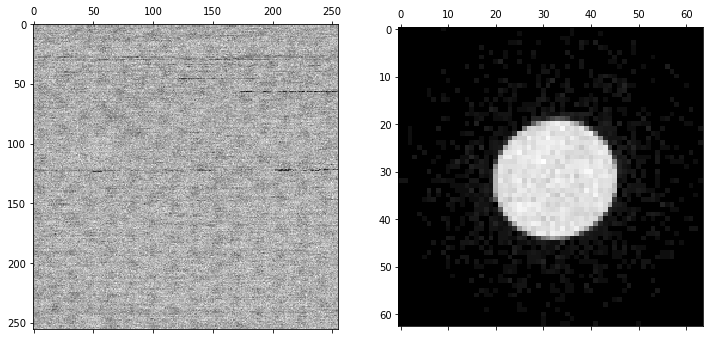

In [32]:
rx,ry = 30,30
power = .5

BF = np.average(dc.data4D,axis=(2,3))
DP = dc.data4D[rx,ry,:,:]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(BF)
ax2.matshow(DP**power)
plt.show()

### Get CBED center and radius

These are used for
1. Calibrating the diffraction plane pixel size
2. Masking the central disk

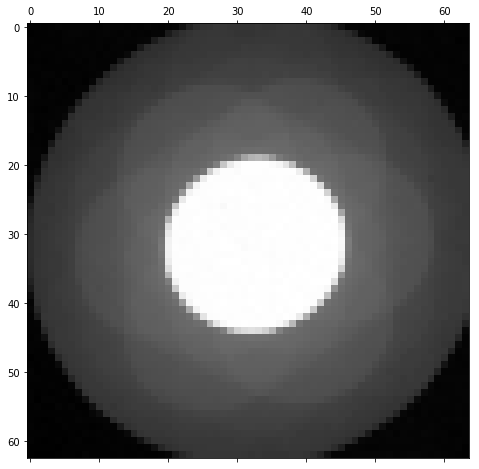

In [4]:
# Get PACBED

power = 0.1

PACBED = np.average(dc.data4D,axis=(0,1))

# Show
fig,ax = plt.subplots(figsize=(8,8,))
ax.matshow(PACBED**power)
plt.show()

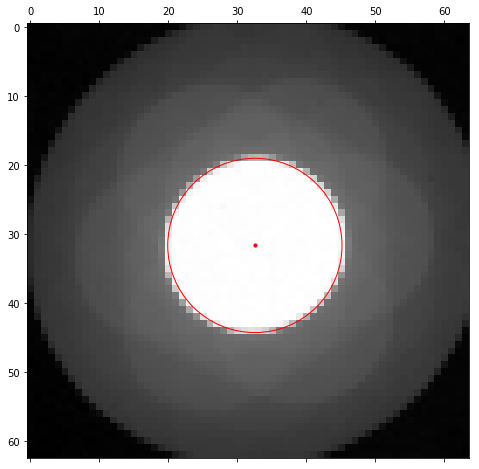

In [5]:
thresh_lower = 0.001
thresh_upper = 0.999
N = 100

r,x0,y0 = get_probe_size(PACBED, thresh_lower=thresh_lower, thresh_upper=thresh_upper, N=N)

# Show
fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(PACBED**power)
ax.scatter(y0,x0,color='r',s=10)
circle = Circle((y0,x0),r,fill=False,edgecolor='r',linewidth=1)
ax.add_patch(circle)
plt.show()

### Get centers of mass

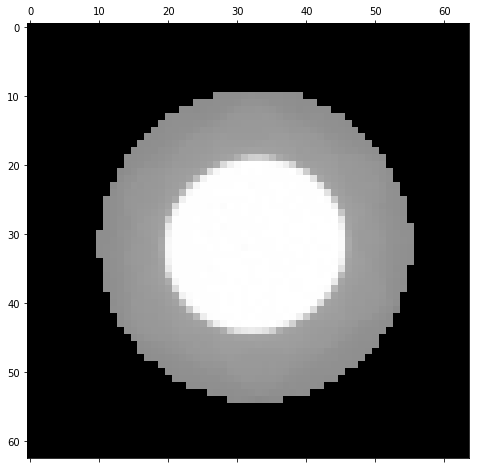

In [6]:
# Get mask

expand = 10

qy,qx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
qr = np.hypot(qx-x0,qy-y0)
mask = qr < r + expand

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow((mask*PACBED)**power)
plt.show()

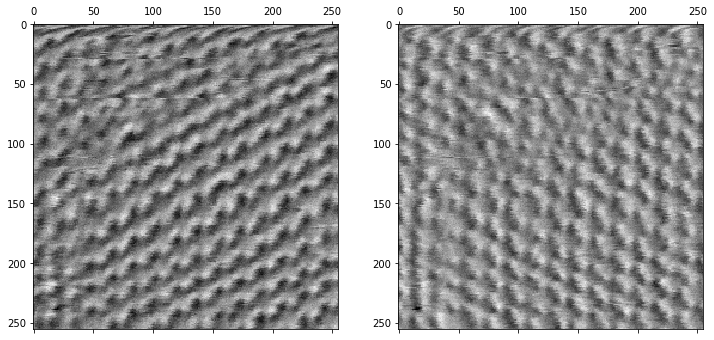

In [7]:
normalize = True

CoMx,CoMy = get_CoM_images(dc, mask=mask, normalize=normalize)

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(CoMx)
ax2.matshow(CoMy)
plt.show()

### Get rotation and flip

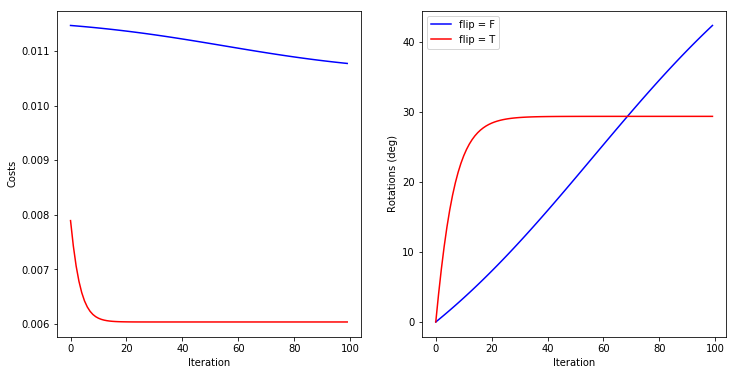

Rotational offset = 29.33 degrees
Flip is set to True


In [8]:
n_iter = 100
stepsize = 4
return_costs = True

theta, flip, thetas, costs, thetas_f, costs_f = get_rotation_and_flip(CoMx, CoMy, dc.Q_Nx, dc.Q_Ny, n_iter=n_iter,
                                                                      stepsize=stepsize, return_costs=return_costs)

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(np.arange(len(thetas)),costs,color='b')
ax1.plot(np.arange(len(thetas_f)),costs_f,color='r')
ax2.plot(np.arange(len(thetas)),np.degrees(thetas),color='b',label='flip = F')
ax2.plot(np.arange(len(thetas_f)),np.degrees(thetas_f),color='r',label='flip = T')
ax1.set_ylabel("Costs")
ax1.set_xlabel("Iteration")
ax2.set_ylabel("Rotations (deg)")
ax2.set_xlabel("Iteration")
ax2.legend()
plt.show()

print("Rotational offset = {:.4} degrees".format(np.degrees(theta)))
print("Flip is set to {}".format(flip))

### Reconstruction

In [54]:
paddingfactor = 2
regLowPass = 200
regHighPass = 0.3
stepSize = 0.5
n_iter = 20

phase, error = get_phase_from_CoM(CoMx, CoMy, theta=theta, flip=flip, regLowPass=regLowPass, regHighPass=regHighPass,
                                  paddingfactor=paddingfactor, stepsize=stepsize, n_iter=n_iter)

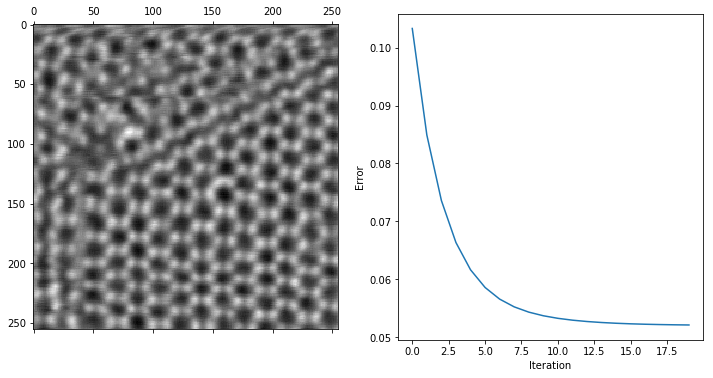

In [55]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(phase)
ax2.plot(np.arange(n_iter),error)
ax2.set_ylabel('Error')
ax2.set_xlabel('Iteration')
plt.show()

### Convert phase to potential

in units of volt-Angstroms, via the interaction constant.

In [58]:
keV = 60                                   # Beam voltage
alpha = 30.6*1e-3                          # Convergence semi-angle, in mrad
kalpha = get_wavenumber(keV*1e3)*alpha
interaction_constant = get_interaction_constant(keV*1e3)

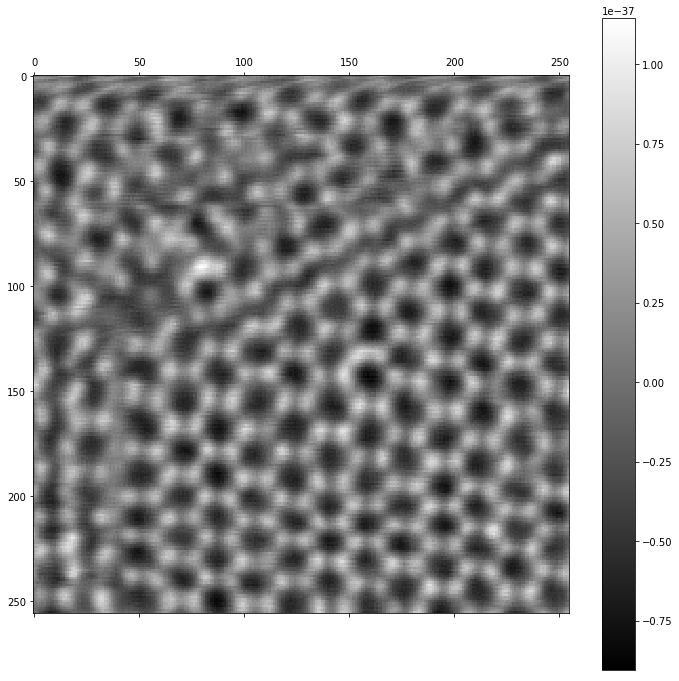

In [59]:
potential_volt_angstroms = phase/interaction_constant

fig,ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(potential_volt_angstroms)
plt.colorbar(cax)
plt.show()